In [1]:
import graph_handling as gh
import centralities
from pprint import pprint

import networkx as nx
import numpy as np
import math
import centralities

We add an edge that links  0  and  4  and check PageRank difference


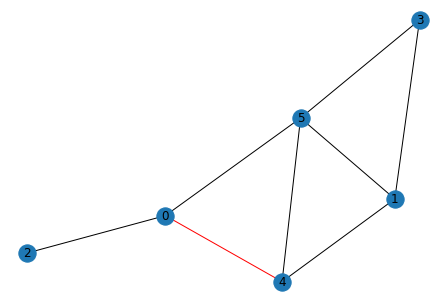

In [2]:
g, ng = gh.random_graphs(6)
x, y = list(set(ng.edges) - set(g.edges))[0]
print('We add an edge that links  ' + str(x) + '  and  ' + str(y) + '  and check PageRank difference')
gh.show(g, x, y)

We compute PageRank vectors for both graphs, remembering that:<br>
- $n$ is the number of nodes of our graph<br>
- $\alpha$ is the damping factor of PageRank<br>
- $\underline{v}$ is the preference vector<br>
- $\overline{A'}$ and $\overline{A}$ are the two adjacency matrices of the graph with and without the new edge

In [3]:
a = 0.85
n = len(g.nodes)
v_vec = np.array([1/n] * n, dtype=float)
v = {int(i):elem for i,elem in enumerate(v_vec)}
for k in v.keys():
    v[k] = round(v[k],8)

pr = centralities.pagerank(g, a, v)
npr = centralities.pagerank(ng, a, v)
pr_vec = np.array([elem[1] for elem in sorted(pr.items())])
npr_vec = np.array([elem[1] for elem in sorted(npr.items())])

We compute the two PageRank vectors: $\;\underline{r'}=\underline{v}(1-\alpha\overline{A'})^{-1}\;$ and $\;\underline{r}=\underline{v}(1-\alpha\overline{A})^{-1}\;$.<br>
Note that we are ignoring the $(1-\alpha)$ constant, and we will do the same for the rest of the computation, eventually putting it back in the end.

In [4]:
A, A_norm = gh.adj_mat(g, False), gh.adj_mat(g, True)
new_A, new_A_norm = gh.adj_mat(ng, False), gh.adj_mat(ng, True)

pr_matrix = np.linalg.inv(np.identity(n) - a*A_norm)
new_pr_matrix = np.linalg.inv(np.identity(n) - a*new_A_norm)

From now on, we will check the math: if our function prints "bad math", we have made a mistake.<br>
Calling $\underline{r'}$ and $\underline{r}$ the two PageRank vectors, we can start computing $\Delta\underline{r}=\underline{r'}-\underline{r}=\underline{v}(1-\alpha\overline{A'})^{-1}-\underline{v}(1-\alpha\overline{A})^{-1}$

In [5]:
r_vec = np.dot(v_vec, pr_matrix)
nr_vec = np.dot(v_vec, new_pr_matrix)

delta_r = nr_vec - r_vec

if not np.isclose((1/(1-a))*npr_vec - (1/(1-a))*pr_vec, delta_r, rtol=1e-5).any():
    print('bad math')

$U$, $C$, and $V$ are matrices that are well defined in the paper and that we use in order to define: $(1-\alpha\overline{A'})^{-1} = (1-\alpha(\overline{A}+UCV))^{-1} = (1-\alpha\overline{A}-\alpha UCV)^{-1}=(B-\alpha UCV)^{-1}$, $\;\;\;$ with $B=1-\alpha\overline{A}$.<br>
In the paper we made a mistake, adding $\;\alpha UCV\;$ instead of subtracting it.

In [6]:
x_deg = (A[x]>0).sum()
y_deg = (A[y]>0).sum()

U = np.zeros((n, 2))
U[x][0]=1
U[y][1]=1
C = np.array([[1/(x_deg**2+x_deg), 0], [0, 1/(y_deg**2+y_deg)]])
V = np.array([[-1 if A[x][i]>0 else x_deg if i==y else 0 for i in range(n)],[-1 if A[y][i]>0 else y_deg if i==x else 0 for i in range(n)]])
B = np.identity(n) - a*A_norm
inv_B = np.linalg.inv(B)

if not np.isclose(new_pr_matrix, np.linalg.inv(B - np.linalg.multi_dot((a*U, C, V))), rtol=1e-20).any():
    print('bad math')

Sherman-Morrison-Woodbury Formula: $(B+UCV)^{-1}=B^{-1}-B^{-1}U(C^{-1}+VB^{-1}U)^{-1}VB^{-1}$.<br>In our case, it becomes: $(B+(-\alpha)UCV)^{-1}=B^{-1}-B^{-1}U((-\alpha C)^{-1}+VB^{-1}U)^{-1}VB^{-1}$.<br>
Let's check if it holds

In [7]:
first = np.linalg.inv(B + np.linalg.multi_dot((U, -a*C, V)))
smw_formula = inv_B - np.linalg.multi_dot((inv_B, U, np.linalg.inv(np.linalg.inv(-a*C) + np.linalg.multi_dot((V, inv_B, U))), V, inv_B))
if not np.isclose(first, smw_formula,rtol=1e-10).any():
    print('bad math')

We can now use the formula to study $\Delta\underline{r}$ . In particular, we want to assure that  $\Delta\underline{r}=\underline{v}(B-\alpha UCV)^{-1}-\underline{v}B^{-1}$

In [8]:
temp = np.dot(v_vec, np.linalg.inv(B - a*np.linalg.multi_dot((U,C,V)))) - np.dot(v_vec, np.linalg.inv(B))
if not np.isclose(delta_r, temp, rtol=1e-10).any():
    print('bad math')

Going to the next step, we apply the formula on $\;(B+(-\alpha)UCV)^{-1}\;$ and check if $\Delta\underline{r}=\underline{v}(B^{-1}-B^{-1}U((-\alpha C)^{-1}+VB^{-1}U)^{-1}VB^{-1})-\underline{r}$

In [9]:
if not np.isclose(delta_r, np.dot(v_vec, smw_formula) - r_vec, rtol=1e-10).any():
    print('bad math')

Last step of the equation<br>
$\Delta\underline{r}=-\underline{v}(B^{-1}U((-\alpha C)^{-1}+VB^{-1}U)^{-1}VB^{-1})=-\underline{r}U((-\alpha C)^{-1}+VB^{-1}U)^{-1}VB^{-1}$

In [10]:
temp = np.linalg.multi_dot((inv_B, U, np.linalg.inv(np.linalg.inv(-a*C) + np.linalg.multi_dot((V, inv_B, U))), V, inv_B))
temp2 = np.linalg.multi_dot((U, np.linalg.inv(np.linalg.inv(-a*C) + np.linalg.multi_dot((V, inv_B, U))), V, inv_B))

if not np.isclose(delta_r, np.dot(-v_vec, temp), rtol=1e-10).any():
    print('bad math')
if not np.isclose(delta_r, np.dot(-r_vec, temp2), rtol=1e-10).any():
    print('bad math')

The math is correct. Now we want to look if there is a random graph for which $\;\Delta\underline{r}_{x}\leq 0\;$ or $\;\Delta\underline{r}_{y}\leq 0\;$.

In [11]:
i = 0
while(i):
    n, a = np.random.randint(5, 50), 0.85
    v_vec = np.array([1/n] * n, dtype=float)
    g, ng = gh.random_graphs(n)
    x, y = list(set(ng.edges) - set(g.edges))[0]

    if centralities.is_smw_right(g, x, y, a, v_vec):
        i += 1
print(i)
print('error')


0
error


In [12]:
i=0
while(i):
    n, a = np.random.randint(5, 50), 0.85
    v_vec = np.array([1/n] * n, dtype=float)
    g, ng = gh.random_graphs(n)
    x, y = list(set(ng.edges) - set(g.edges))[0]
    delta_r = centralities.delta_r(g, x, y, a, v_vec)
    if delta_r[x]<=0 or delta_r[y]<=0:
        print('found with my function')
        break
    
    pr = nx.pagerank(g, a)
    npr = nx.pagerank(ng, a)
    pr_vec = np.array([elem[1] for elem in sorted(pr.items())])
    npr_vec = np.array([elem[1] for elem in sorted(npr.items())])
    
    if (npr_vec - pr_vec)[x]<=0 or (npr_vec - pr_vec)[y]<=0:
        print('found')
        final_graph, new_final_graph, final_x, final_y = g, ng, x, y
        break


In [13]:
final_pagerank = nx.pagerank(final_graph)
new_final_pagerank = nx.pagerank(new_final_graph)

NameError: name 'final_graph' is not defined